In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all available preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60205 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:60208" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:60234, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:60228, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:60231, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

In [5]:
train_y = train_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})
test_y = test_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})

### SGD Classifier

We will start with the Random Forest Classifier which is pretty common becuase of it's predicitive power. We will run using all features first and then we can compare the different amount of features to see what performs best.

In [6]:
sgd = SGDClassifier(verbose=1)
with joblib.parallel_backend('dask'):
    sgd.fit(train_X, train_y)
sgd.score(test_X, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 28.45, NNZs: 369, Bias: -10.216000, T: 44550, Avg. loss: 4.427436
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 18.60, NNZs: 370, Bias: -9.005433, T: 89100, Avg. loss: 1.159706
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 14.88, NNZs: 370, Bias: -8.019181, T: 133650, Avg. loss: 0.853279
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 13.18, NNZs: 370, Bias: -7.250066, T: 178200, Avg. loss: 0.734526
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 12.04, NNZs: 370, Bias: -6.961177, T: 222750, Avg. loss: 0.666873
Total training time: 0.26 seconds.
-- Epoch 6
Norm: 11.39, NNZs: 370, Bias: -6.693199, T: 267300, Avg. loss: 0.627240
Total training time: 0.31 seconds.
-- Epoch 7
Norm: 10.86, NNZs: 370, Bias: -6.366267, T: 311850, Avg. loss: 0.598769
Total training time: 0.36 seconds.
-- Epoch 8
Norm: 10.17, NNZs: 370, Bias: -6.395145, T: 356400, Avg. loss: 0.570820
Total training time: 0.40 seconds.
-- Epoch 9
Norm: 9.81, NNZs: 370, Bias: -6.153447, T: 400

Norm: 4.61, NNZs: 368, Bias: -7.134967, T: 1291950, Avg. loss: 0.164830
Total training time: 1.33 seconds.
-- Epoch 30
Norm: 4.51, NNZs: 368, Bias: -7.104091, T: 1336500, Avg. loss: 0.164279
Total training time: 1.38 seconds.
-- Epoch 31
Norm: 4.51, NNZs: 368, Bias: -7.037519, T: 1381050, Avg. loss: 0.163424
Total training time: 1.43 seconds.
-- Epoch 32
Norm: 4.48, NNZs: 368, Bias: -6.966580, T: 1425600, Avg. loss: 0.162889
Total training time: 1.48 seconds.
-- Epoch 33
Norm: 4.42, NNZs: 368, Bias: -6.938782, T: 1470150, Avg. loss: 0.162525
Total training time: 1.51 seconds.
-- Epoch 34
Norm: 4.37, NNZs: 368, Bias: -6.897883, T: 1514700, Avg. loss: 0.162220
Total training time: 1.57 seconds.
Convergence after 34 epochs took 1.57 seconds
-- Epoch 1
Norm: 27.77, NNZs: 370, Bias: 3.012093, T: 44550, Avg. loss: 5.153504
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 18.79, NNZs: 370, Bias: 2.172743, T: 89100, Avg. loss: 1.337379
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 14.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s finished


0.7482154882154882

In [7]:
sgd_deets = pd.DataFrame(sgd.get_params(), index=['SGD_OBO'])
sgd_deets.insert(0, value=sgd.score(test_X, test_y), column='Accuracy')
sgd_deets

,Accuracy,alpha,average,class_weight,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,...,n_iter_no_change,n_jobs,penalty,power_t,random_state,shuffle,tol,validation_fraction,verbose,warm_start
SGD_OBO,0.748215,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False


In [8]:
sgd_bal = SGDClassifier(class_weight='balanced', verbose=True)
with joblib.parallel_backend('dask'):
    sgd_bal.fit(train_X, train_y)
sgd_bal.score(test_X, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 25.74, NNZs: 369, Bias: -9.740978, T: 44550, Avg. loss: 4.197966
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 17.38, NNZs: 370, Bias: -8.670630, T: 89100, Avg. loss: 1.101210
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 13.83, NNZs: 370, Bias: -7.878063, T: 133650, Avg. loss: 0.829880
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 12.29, NNZs: 370, Bias: -7.260446, T: 178200, Avg. loss: 0.712455
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 11.18, NNZs: 370, Bias: -6.980700, T: 222750, Avg. loss: 0.645683
Total training time: 0.26 seconds.
-- Epoch 6
Norm: 10.65, NNZs: 370, Bias: -6.717078, T: 267300, Avg. loss: 0.609503
Total training time: 0.31 seconds.
-- Epoch 7
Norm: 9.95, NNZs: 370, Bias: -6.463749, T: 311850, Avg. loss: 0.581865
Total training time: 0.34 seconds.
-- Epoch 8
Norm: 9.60, NNZs: 370, Bias: -6.256807, T: 356400, Avg. loss: 0.563307
Total training time: 0.40 seconds.
-- Epoch 9
Norm: 9.28, NNZs: 370, Bias: -6.100357, T: 400950

Norm: 14.24, NNZs: 369, Bias: -7.662885, T: 712800, Avg. loss: 0.414674
Total training time: 0.76 seconds.
-- Epoch 17
Norm: 13.94, NNZs: 369, Bias: -7.703592, T: 757350, Avg. loss: 0.402793
Total training time: 0.80 seconds.
-- Epoch 18
Norm: 13.68, NNZs: 369, Bias: -7.399308, T: 801900, Avg. loss: 0.392136
Total training time: 0.87 seconds.
-- Epoch 19
Norm: 13.55, NNZs: 369, Bias: -7.391700, T: 846450, Avg. loss: 0.396598
Total training time: 0.92 seconds.
-- Epoch 20
Norm: 13.15, NNZs: 369, Bias: -7.348449, T: 891000, Avg. loss: 0.390634
Total training time: 0.95 seconds.
-- Epoch 21
Norm: 12.91, NNZs: 369, Bias: -7.202597, T: 935550, Avg. loss: 0.378332
Total training time: 1.01 seconds.
-- Epoch 22
Norm: 12.81, NNZs: 369, Bias: -7.155457, T: 980100, Avg. loss: 0.377257
Total training time: 1.06 seconds.
-- Epoch 23
Norm: 12.70, NNZs: 369, Bias: -7.152933, T: 1024650, Avg. loss: 0.370230
Total training time: 1.11 seconds.
-- Epoch 24
Norm: 12.61, NNZs: 369, Bias: -7.002190, T: 106

Norm: 8.47, NNZs: 370, Bias: 0.151594, T: 1247400, Avg. loss: 0.589020
Total training time: 1.40 seconds.
-- Epoch 29
Norm: 8.38, NNZs: 370, Bias: 0.117274, T: 1291950, Avg. loss: 0.587596
Total training time: 1.45 seconds.
-- Epoch 30
Norm: 8.36, NNZs: 370, Bias: 0.131591, T: 1336500, Avg. loss: 0.583492
Total training time: 1.48 seconds.
-- Epoch 31
Norm: 8.32, NNZs: 370, Bias: 0.140454, T: 1381050, Avg. loss: 0.581189
Total training time: 1.53 seconds.
-- Epoch 32
Norm: 8.31, NNZs: 370, Bias: 0.123502, T: 1425600, Avg. loss: 0.583827
Total training time: 1.58 seconds.
-- Epoch 33
Norm: 8.31, NNZs: 370, Bias: 0.175010, T: 1470150, Avg. loss: 0.582565
Total training time: 1.64 seconds.
-- Epoch 34
Norm: 8.30, NNZs: 370, Bias: 0.181450, T: 1514700, Avg. loss: 0.581501
Total training time: 1.68 seconds.
-- Epoch 35
Norm: 8.27, NNZs: 370, Bias: 0.148685, T: 1559250, Avg. loss: 0.582117
Total training time: 1.73 seconds.
-- Epoch 36
Norm: 8.29, NNZs: 370, Bias: 0.162509, T: 1603800, Avg. 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.5s finished


0.7346127946127946

This performs pretty well. We can further tune some hyperparamters to possibly get higher accuracy. Let's start with class weights. But we need to first save the parameters and score for later review.

In [9]:
a = sgd_bal.get_params()
a['Accuracy'] = sgd_bal.score(test_X, test_y)
sgd_deets = pd.concat([sgd_deets, pd.DataFrame(a, index=['SGD_BAL'])], axis=0, join='outer')
sgd_deets

,Accuracy,alpha,average,class_weight,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,...,n_iter_no_change,n_jobs,penalty,power_t,random_state,shuffle,tol,validation_fraction,verbose,warm_start
SGD_OBO,0.748215,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_BAL,0.734613,0.0001,False,balanced,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False


In [10]:
sgd_el = SGDClassifier(verbose=True, penalty='elasticnet', learning_rate='optimal', l1_ratio=0.15)
with joblib.parallel_backend('dask'):
    sgd_el.fit(train_X, train_y)
sgd_el.score(test_X, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 63.40, NNZs: 293, Bias: -4.240787, T: 44550, Avg. loss: 4.325091
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 57.26, NNZs: 270, Bias: -3.518457, T: 89100, Avg. loss: 0.953986
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 52.49, NNZs: 261, Bias: -3.228333, T: 133650, Avg. loss: 0.728883
Total training time: 0.72 seconds.
-- Epoch 4
Norm: 48.40, NNZs: 271, Bias: -3.059384, T: 178200, Avg. loss: 0.635169
Total training time: 0.97 seconds.
-- Epoch 5
Norm: 44.84, NNZs: 279, Bias: -2.871723, T: 222750, Avg. loss: 0.595293
Total training time: 1.20 seconds.
-- Epoch 6
Norm: 42.03, NNZs: 267, Bias: -2.509829, T: 267300, Avg. loss: 0.565082
Total training time: 1.40 seconds.
-- Epoch 7
Norm: 39.66, NNZs: 275, Bias: -2.475840, T: 311850, Avg. loss: 0.549326
Total training time: 1.63 seconds.
-- Epoch 8
Norm: 37.63, NNZs: 276, Bias: -2.387907, T: 356400, Avg. loss: 0.532411
Total training time: 1.85 seconds.
-- Epoch 9
Norm: 35.78, NNZs: 272, Bias: -2.352460, T: 400

Norm: 14.27, NNZs: 249, Bias: -4.499606, T: 1247400, Avg. loss: 0.159315
Total training time: 5.70 seconds.
-- Epoch 29
Norm: 14.03, NNZs: 248, Bias: -4.468445, T: 1291950, Avg. loss: 0.158232
Total training time: 5.91 seconds.
-- Epoch 30
Norm: 13.80, NNZs: 250, Bias: -4.415444, T: 1336500, Avg. loss: 0.158003
Total training time: 6.12 seconds.
-- Epoch 31
Norm: 13.58, NNZs: 255, Bias: -4.371041, T: 1381050, Avg. loss: 0.157763
Total training time: 6.31 seconds.
-- Epoch 32
Norm: 13.37, NNZs: 249, Bias: -4.307223, T: 1425600, Avg. loss: 0.157350
Total training time: 6.51 seconds.
-- Epoch 33
Norm: 13.18, NNZs: 250, Bias: -4.245745, T: 1470150, Avg. loss: 0.156810
Total training time: 6.70 seconds.
-- Epoch 34
Norm: 12.98, NNZs: 247, Bias: -4.212734, T: 1514700, Avg. loss: 0.156596
Total training time: 6.90 seconds.
Convergence after 34 epochs took 6.90 seconds
-- Epoch 1
Norm: 69.57, NNZs: 277, Bias: 4.476317, T: 44550, Avg. loss: 4.917799
Total training time: 0.25 seconds.
-- Epoch 2

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s finished


0.749023569023569

In [11]:
a = sgd_el.get_params()
a['Accuracy'] = sgd_el.score(test_X, test_y)
sgd_deets = pd.concat([sgd_deets, pd.DataFrame(a, index=['SGD_EL'])], axis=0, join='outer')
sgd_deets

,Accuracy,alpha,average,class_weight,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,...,n_iter_no_change,n_jobs,penalty,power_t,random_state,shuffle,tol,validation_fraction,verbose,warm_start
SGD_OBO,0.748215,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_BAL,0.734613,0.0001,False,balanced,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_EL,0.749024,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False


In [20]:
sgd_adapt = SGDClassifier(verbose=True, penalty='elasticnet', learning_rate='adaptive', l1_ratio=0.15, eta0=5)
with joblib.parallel_backend('dask'):
    sgd_adapt.fit(train_X, train_y)
sgd_adapt.score(test_X, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 284.53, NNZs: 295, Bias: -30.000000, T: 44550, Avg. loss: 21.699176
Total training time: 0.26 seconds.
-- Epoch 2
Norm: 321.80, NNZs: 244, Bias: -30.000000, T: 89100, Avg. loss: 19.222923
Total training time: 0.50 seconds.
-- Epoch 3
Norm: 340.09, NNZs: 197, Bias: -20.000000, T: 133650, Avg. loss: 17.221352
Total training time: 0.75 seconds.
-- Epoch 4
Norm: 383.11, NNZs: 202, Bias: -25.000000, T: 178200, Avg. loss: 15.872652
Total training time: 1.00 seconds.
-- Epoch 5
Norm: 395.25, NNZs: 191, Bias: -15.000000, T: 222750, Avg. loss: 14.690560
Total training time: 1.26 seconds.
-- Epoch 6
Norm: 400.90, NNZs: 163, Bias: -30.000000, T: 267300, Avg. loss: 13.751594
Total training time: 1.50 seconds.
-- Epoch 7
Norm: 396.89, NNZs: 175, Bias: -45.000000, T: 311850, Avg. loss: 13.051051
Total training time: 1.75 seconds.
-- Epoch 8
Norm: 413.29, NNZs: 185, Bias: -15.000000, T: 356400, Avg. loss: 12.854008
Total training time: 1.99 seconds.
-- Epoch 9
Norm: 423.44, NNZs: 164

Norm: 32.73, NNZs: 228, Bias: -2.152000, T: 3073950, Avg. loss: 0.462070
Total training time: 16.29 seconds.
-- Epoch 70
Norm: 31.98, NNZs: 226, Bias: -2.064000, T: 3118500, Avg. loss: 0.462777
Total training time: 16.51 seconds.
-- Epoch 71
Norm: 31.28, NNZs: 229, Bias: -2.008000, T: 3163050, Avg. loss: 0.461223
Total training time: 16.75 seconds.
-- Epoch 72
Norm: 31.09, NNZs: 230, Bias: -2.017600, T: 3207600, Avg. loss: 0.444006
Total training time: 16.96 seconds.
-- Epoch 73
Norm: 30.91, NNZs: 229, Bias: -1.979200, T: 3252150, Avg. loss: 0.443065
Total training time: 17.20 seconds.
-- Epoch 74
Norm: 30.72, NNZs: 231, Bias: -1.979200, T: 3296700, Avg. loss: 0.442153
Total training time: 17.43 seconds.
-- Epoch 75
Norm: 30.55, NNZs: 229, Bias: -1.969600, T: 3341250, Avg. loss: 0.442159
Total training time: 17.67 seconds.
-- Epoch 76
Norm: 30.37, NNZs: 227, Bias: -1.955200, T: 3385800, Avg. loss: 0.442041
Total training time: 17.90 seconds.
-- Epoch 77
Norm: 30.20, NNZs: 231, Bias: -1

Norm: 143.56, NNZs: 120, Bias: -12.000000, T: 1559250, Avg. loss: 0.689735
Total training time: 7.35 seconds.
-- Epoch 36
Norm: 136.96, NNZs: 137, Bias: -10.000000, T: 1603800, Avg. loss: 0.706887
Total training time: 7.55 seconds.
-- Epoch 37
Norm: 133.67, NNZs: 138, Bias: -10.000000, T: 1648350, Avg. loss: 0.793640
Total training time: 7.75 seconds.
-- Epoch 38
Norm: 132.68, NNZs: 136, Bias: -8.000000, T: 1692900, Avg. loss: 0.798901
Total training time: 7.95 seconds.
-- Epoch 39
Norm: 127.46, NNZs: 160, Bias: -9.000000, T: 1737450, Avg. loss: 0.861716
Total training time: 8.16 seconds.
-- Epoch 40
Norm: 124.92, NNZs: 167, Bias: -9.000000, T: 1782000, Avg. loss: 0.918331
Total training time: 8.38 seconds.
-- Epoch 41
Norm: 79.86, NNZs: 158, Bias: -4.200000, T: 1826550, Avg. loss: 0.300164
Total training time: 8.59 seconds.
-- Epoch 42
Norm: 66.79, NNZs: 165, Bias: -4.200000, T: 1871100, Avg. loss: 0.287611
Total training time: 8.80 seconds.
-- Epoch 43
Norm: 63.33, NNZs: 157, Bias: -

Norm: 438.49, NNZs: 177, Bias: 5.000000, T: 356400, Avg. loss: 13.600506
Total training time: 2.03 seconds.
-- Epoch 9
Norm: 443.53, NNZs: 148, Bias: 10.000000, T: 400950, Avg. loss: 13.494617
Total training time: 2.26 seconds.
-- Epoch 10
Norm: 448.89, NNZs: 147, Bias: -10.000000, T: 445500, Avg. loss: 13.042550
Total training time: 2.48 seconds.
-- Epoch 11
Norm: 447.87, NNZs: 131, Bias: 20.000000, T: 490050, Avg. loss: 12.855857
Total training time: 2.72 seconds.
-- Epoch 12
Norm: 479.17, NNZs: 152, Bias: 10.000000, T: 534600, Avg. loss: 12.081544
Total training time: 2.94 seconds.
-- Epoch 13
Norm: 467.34, NNZs: 151, Bias: 5.000000, T: 579150, Avg. loss: 12.337164
Total training time: 3.17 seconds.
-- Epoch 14
Norm: 466.10, NNZs: 143, Bias: 10.000000, T: 623700, Avg. loss: 12.032287
Total training time: 3.38 seconds.
-- Epoch 15
Norm: 479.90, NNZs: 131, Bias: 10.000000, T: 668250, Avg. loss: 11.600915
Total training time: 3.61 seconds.
-- Epoch 16
Norm: 459.34, NNZs: 146, Bias: 15.

Norm: 39.13, NNZs: 232, Bias: 0.578816, T: 3430350, Avg. loss: 0.520260
Total training time: 18.36 seconds.
-- Epoch 78
Norm: 39.12, NNZs: 232, Bias: 0.581760, T: 3474900, Avg. loss: 0.520058
Total training time: 18.61 seconds.
-- Epoch 79
Norm: 39.11, NNZs: 232, Bias: 0.576448, T: 3519450, Avg. loss: 0.520081
Total training time: 18.85 seconds.
-- Epoch 80
Norm: 39.10, NNZs: 232, Bias: 0.579520, T: 3564000, Avg. loss: 0.520046
Total training time: 19.09 seconds.
-- Epoch 81
Norm: 39.09, NNZs: 232, Bias: 0.578304, T: 3608550, Avg. loss: 0.520024
Total training time: 19.36 seconds.
-- Epoch 82
Norm: 39.09, NNZs: 232, Bias: 0.577766, T: 3653100, Avg. loss: 0.519809
Total training time: 19.61 seconds.
-- Epoch 83
Norm: 39.09, NNZs: 232, Bias: 0.577446, T: 3697650, Avg. loss: 0.519770
Total training time: 19.86 seconds.
-- Epoch 84
Norm: 39.09, NNZs: 232, Bias: 0.577498, T: 3742200, Avg. loss: 0.519783
Total training time: 20.10 seconds.
-- Epoch 85
Norm: 39.09, NNZs: 232, Bias: 0.577728, 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


0.7486195286195286

In [13]:
a = sgd_adapt.get_params()
a['Accuracy'] = sgd_adapt.score(test_X, test_y)
sgd_deets = pd.concat([sgd_deets, pd.DataFrame(a, index=['SGD_ADP'])], axis=0, join='outer')
sgd_deets

,Accuracy,alpha,average,class_weight,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,...,n_iter_no_change,n_jobs,penalty,power_t,random_state,shuffle,tol,validation_fraction,verbose,warm_start
SGD_OBO,0.748215,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_BAL,0.734613,0.0001,False,balanced,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_EL,0.749024,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False
SGD_ADP,0.749630,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False


In [14]:
sgd_huber = SGDClassifier(loss='modified_huber', learning_rate='optimal', l1_ratio=0.15)
with joblib.parallel_backend('dask'):
    sgd_huber.fit(train_X, train_y)
sgd_huber.score(test_X, test_y)

0.7346801346801347

In [15]:
a = sgd_huber.get_params()
a['Accuracy'] = sgd_huber.score(test_X, test_y)
sgd_deets = pd.concat([sgd_deets, pd.DataFrame(a, index=['SGD_HUB'])], axis=0, join='outer')
sgd_deets

,Accuracy,alpha,average,class_weight,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,...,n_iter_no_change,n_jobs,penalty,power_t,random_state,shuffle,tol,validation_fraction,verbose,warm_start
SGD_OBO,0.748215,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_BAL,0.734613,0.0001,False,balanced,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_EL,0.749024,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False
SGD_ADP,0.749630,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False
SGD_HUB,0.734680,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,0,False


In [24]:
#run through loop for hyperparameter tuning
loss_opt = ['hinge', 'squared_hinge', 'modified_huber'] 
l1_ratio = [0, .1, .3, .5, .7, 1]
penalty = 'elasticnet'
class_weight=[None, 'balanced']
for weight in class_weight:
    for loss in loss_opt:
        for l1 in l1_ratio:
            sgd = SGDClassifier(loss=loss, l1_ratio=l1, penalty=penalty, class_weight=weight)
            with joblib.parallel_backend('dask'):
                sgd.fit(train_X, train_y)    
            deets = sgd.get_params()
            deets['Accuracy']=sgd.score(test_X, test_y)
            sgd_deets = pd.concat([sgd_deets, pd.DataFrame(deets, 
                    index=['SGD_{loss}_{l1}_{weight}'.format(loss=loss,l1=l1, weight=weight)])], axis=0, join='outer')

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: Convergence

In [25]:
sgd_deets

,Accuracy,alpha,average,class_weight,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,...,n_iter_no_change,n_jobs,penalty,power_t,random_state,shuffle,tol,validation_fraction,verbose,warm_start
SGD_OBO,0.748215,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_BAL,0.734613,0.0001,False,balanced,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,1,False
SGD_EL,0.749024,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False
SGD_ADP,0.749630,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,1,False
SGD_HUB,0.734680,0.0001,False,None,False,0.1,0.0,True,0.15,optimal,...,5,None,l2,0.5,None,True,0.001,0.1,0,False
SGD_hinge_0_None,0.750303,0.0001,False,None,False,0.1,0.0,True,0.00,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,0,False
SGD_hinge_0.1_None,0.748350,0.0001,False,None,False,0.1,0.0,True,0.10,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,0,False
SGD_hinge_0.3_None,0.749024,0.0001,False,None,False,0.1,0.0,True,0.30,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,0,False
SGD_hinge_0.5_None,0.748552,0.0001,False,None,False,0.1,0.0,True,0.50,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,0,False
SGD_hinge_0.7_None,0.746936,0.0001,False,None,False,0.1,0.0,True,0.70,optimal,...,5,None,elasticnet,0.5,None,True,0.001,0.1,0,False


<Figure size 2880x576 with 0 Axes>

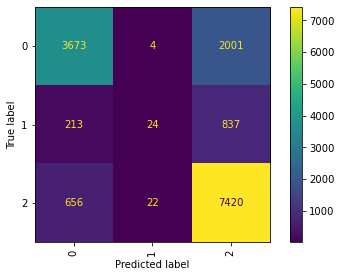

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      5678
           1       0.48      0.02      0.04      1074
           2       0.72      0.92      0.81      8098

    accuracy                           0.75     14850
   macro avg       0.67      0.53      0.52     14850
weighted avg       0.74      0.75      0.72     14850



In [26]:
#visual metrics on class basis for best model using confusion matrix and classificaiton report
y_pred = sgd_adapt.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=sgd_adapt.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=sgd_adapt.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=sgd_adapt.classes_))

In [27]:
#Confirm generalizability with 5 fold cross validation
print(cross_val_score(sgd_adapt, train_X, train_y, cv=5))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 287.55, NNZs: 304, Bias: -35.000000, T: 35640, Avg. loss: 21.925194
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 299.61, NNZs: 264, Bias: -20.000000, T: 71280, Avg. loss: 19.832615
Total training time: 0.39 seconds.
-- Epoch 3
Norm: 348.22, NNZs: 218, Bias: -35.000000, T: 106920, Avg. loss: 18.092534
Total training time: 0.59 seconds.
-- Epoch 4
Norm: 369.29, NNZs: 199, Bias: -35.000000, T: 142560, Avg. loss: 16.799689
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 366.27, NNZs: 207, Bias: -25.000000, T: 178200, Avg. loss: 15.507760
Total training time: 0.99 seconds.
-- Epoch 6
Norm: 418.72, NNZs: 184, Bias: -30.000000, T: 213840, Avg. loss: 14.387578
Total training time: 1.19 seconds.
-- Epoch 7
Norm: 411.26, NNZs: 192, Bias: -25.000000, T: 249480, Avg. loss: 13.833711
Total training time: 1.38 seconds.
-- Epoch 8
Norm: 403.62, NNZs: 188, Bias: -20.000000, T: 285120, Avg. loss: 13.631066
Total training time: 1.57 seconds.
-- Epoch 9
Norm: 418.92, NNZs: 153

Norm: 37.49, NNZs: 228, Bias: -1.990400, T: 2494800, Avg. loss: 0.438947
Total training time: 13.08 seconds.
-- Epoch 71
Norm: 37.45, NNZs: 229, Bias: -1.987200, T: 2530440, Avg. loss: 0.438873
Total training time: 13.26 seconds.
-- Epoch 72
Norm: 37.42, NNZs: 231, Bias: -1.977600, T: 2566080, Avg. loss: 0.438796
Total training time: 13.44 seconds.
-- Epoch 73
Norm: 37.38, NNZs: 230, Bias: -1.974080, T: 2601720, Avg. loss: 0.438710
Total training time: 13.63 seconds.
-- Epoch 74
Norm: 37.35, NNZs: 230, Bias: -1.975360, T: 2637360, Avg. loss: 0.438817
Total training time: 13.82 seconds.
-- Epoch 75
Norm: 37.34, NNZs: 230, Bias: -1.974080, T: 2673000, Avg. loss: 0.437836
Total training time: 14.00 seconds.
-- Epoch 76
Norm: 37.33, NNZs: 230, Bias: -1.974656, T: 2708640, Avg. loss: 0.437794
Total training time: 14.19 seconds.
-- Epoch 77
Norm: 37.32, NNZs: 230, Bias: -1.972736, T: 2744280, Avg. loss: 0.437792
Total training time: 14.37 seconds.
-- Epoch 78
Norm: 37.32, NNZs: 230, Bias: -1

Norm: 45.06, NNZs: 184, Bias: -2.040000, T: 1568160, Avg. loss: 0.185172
Total training time: 7.75 seconds.
-- Epoch 45
Norm: 41.78, NNZs: 186, Bias: -2.160000, T: 1603800, Avg. loss: 0.186954
Total training time: 7.92 seconds.
-- Epoch 46
Norm: 39.06, NNZs: 186, Bias: -2.080000, T: 1639440, Avg. loss: 0.185945
Total training time: 8.10 seconds.
-- Epoch 47
Norm: 36.78, NNZs: 185, Bias: -2.200000, T: 1675080, Avg. loss: 0.186046
Total training time: 8.27 seconds.
-- Epoch 48
Norm: 34.85, NNZs: 184, Bias: -2.040000, T: 1710720, Avg. loss: 0.186247
Total training time: 8.44 seconds.
-- Epoch 49
Norm: 34.06, NNZs: 182, Bias: -1.720000, T: 1746360, Avg. loss: 0.161965
Total training time: 8.63 seconds.
-- Epoch 50
Norm: 33.32, NNZs: 185, Bias: -1.552000, T: 1782000, Avg. loss: 0.157108
Total training time: 8.80 seconds.
-- Epoch 51
Norm: 32.62, NNZs: 177, Bias: -1.464000, T: 1817640, Avg. loss: 0.155549
Total training time: 8.97 seconds.
-- Epoch 52
Norm: 31.94, NNZs: 175, Bias: -1.360000,

Norm: 455.05, NNZs: 155, Bias: -5.000000, T: 819720, Avg. loss: 11.660953
Total training time: 4.27 seconds.
-- Epoch 24
Norm: 473.21, NNZs: 144, Bias: 5.000000, T: 855360, Avg. loss: 11.327157
Total training time: 4.45 seconds.
-- Epoch 25
Norm: 484.53, NNZs: 142, Bias: 15.000000, T: 891000, Avg. loss: 10.902349
Total training time: 4.63 seconds.
-- Epoch 26
Norm: 473.10, NNZs: 143, Bias: 5.000000, T: 926640, Avg. loss: 11.414907
Total training time: 4.81 seconds.
-- Epoch 27
Norm: 493.25, NNZs: 128, Bias: 10.000000, T: 962280, Avg. loss: 10.805804
Total training time: 4.99 seconds.
-- Epoch 28
Norm: 458.24, NNZs: 147, Bias: 10.000000, T: 997920, Avg. loss: 11.065106
Total training time: 5.17 seconds.
-- Epoch 29
Norm: 469.66, NNZs: 155, Bias: -5.000000, T: 1033560, Avg. loss: 11.005775
Total training time: 5.35 seconds.
-- Epoch 30
Norm: 504.55, NNZs: 135, Bias: 5.000000, T: 1069200, Avg. loss: 10.643246
Total training time: 5.53 seconds.
-- Epoch 31
Norm: 488.46, NNZs: 139, Bias: 10

Norm: 43.21, NNZs: 227, Bias: 0.790563, T: 3278880, Avg. loss: 0.522742
Total training time: 17.49 seconds.
-- Epoch 93
Norm: 43.21, NNZs: 227, Bias: 0.790561, T: 3314520, Avg. loss: 0.522742
Total training time: 17.67 seconds.
-- Epoch 94
Norm: 43.21, NNZs: 227, Bias: 0.790561, T: 3350160, Avg. loss: 0.522742
Total training time: 17.87 seconds.
Convergence after 94 epochs took 17.87 seconds


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 280.06, NNZs: 308, Bias: -50.000000, T: 35640, Avg. loss: 22.039345
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 302.77, NNZs: 258, Bias: -40.000000, T: 71280, Avg. loss: 19.918299
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 339.85, NNZs: 227, Bias: -30.000000, T: 106920, Avg. loss: 18.278891
Total training time: 0.62 seconds.
-- Epoch 4
Norm: 364.92, NNZs: 228, Bias: -25.000000, T: 142560, Avg. loss: 17.110609
Total training time: 0.82 seconds.
-- Epoch 5
Norm: 377.93, NNZs: 187, Bias: -35.000000, T: 178200, Avg. loss: 15.525460
Total training time: 1.01 seconds.
-- Epoch 6
Norm: 384.65, NNZs: 179, Bias: -30.000000, T: 213840, Avg. loss: 14.967670
Total training time: 1.21 seconds.
-- Epoch 7
Norm: 389.75, NNZs: 183, Bias: -40.000000, T: 249480, Avg. loss: 14.135530
Total training time: 1.40 seconds.
-- Epoch 8
Norm: 397.58, NNZs: 188, Bias: -40.000000, T: 285120, Avg. loss: 13.612761
Total training time: 1.58 seconds.
-- Epoch 9
Norm: 393.90, NNZs: 173

Norm: 41.02, NNZs: 231, Bias: -1.650112, T: 2494800, Avg. loss: 0.437414
Total training time: 12.94 seconds.
-- Epoch 71
Norm: 41.01, NNZs: 231, Bias: -1.650176, T: 2530440, Avg. loss: 0.437371
Total training time: 13.13 seconds.
-- Epoch 72
Norm: 41.00, NNZs: 231, Bias: -1.651840, T: 2566080, Avg. loss: 0.437346
Total training time: 13.32 seconds.
-- Epoch 73
Norm: 40.99, NNZs: 231, Bias: -1.649728, T: 2601720, Avg. loss: 0.437308
Total training time: 13.50 seconds.
-- Epoch 74
Norm: 40.98, NNZs: 231, Bias: -1.648064, T: 2637360, Avg. loss: 0.437322
Total training time: 13.68 seconds.
-- Epoch 75
Norm: 40.98, NNZs: 231, Bias: -1.648550, T: 2673000, Avg. loss: 0.437144
Total training time: 13.86 seconds.
-- Epoch 76
Norm: 40.98, NNZs: 231, Bias: -1.647949, T: 2708640, Avg. loss: 0.437136
Total training time: 14.03 seconds.
-- Epoch 77
Norm: 40.98, NNZs: 231, Bias: -1.648038, T: 2744280, Avg. loss: 0.437125
Total training time: 14.21 seconds.
-- Epoch 78
Norm: 40.98, NNZs: 231, Bias: -1

Norm: 49.26, NNZs: 184, Bias: -2.600000, T: 1746360, Avg. loss: 0.186777
Total training time: 8.79 seconds.
-- Epoch 50
Norm: 45.44, NNZs: 182, Bias: -2.320000, T: 1782000, Avg. loss: 0.183487
Total training time: 8.99 seconds.
-- Epoch 51
Norm: 42.14, NNZs: 184, Bias: -2.040000, T: 1817640, Avg. loss: 0.185125
Total training time: 9.17 seconds.
-- Epoch 52
Norm: 39.43, NNZs: 188, Bias: -1.880000, T: 1853280, Avg. loss: 0.183462
Total training time: 9.37 seconds.
-- Epoch 53
Norm: 37.08, NNZs: 199, Bias: -1.920000, T: 1888920, Avg. loss: 0.184909
Total training time: 9.55 seconds.
-- Epoch 54
Norm: 35.13, NNZs: 195, Bias: -1.800000, T: 1924560, Avg. loss: 0.185819
Total training time: 9.71 seconds.
-- Epoch 55
Norm: 33.53, NNZs: 192, Bias: -2.000000, T: 1960200, Avg. loss: 0.186988
Total training time: 9.89 seconds.
-- Epoch 56
Norm: 32.78, NNZs: 195, Bias: -1.680000, T: 1995840, Avg. loss: 0.160741
Total training time: 10.07 seconds.
-- Epoch 57
Norm: 32.09, NNZs: 184, Bias: -1.520000

Norm: 450.32, NNZs: 151, Bias: 10.000000, T: 855360, Avg. loss: 10.848763
Total training time: 4.73 seconds.
-- Epoch 25
Norm: 468.33, NNZs: 160, Bias: 10.000000, T: 891000, Avg. loss: 11.474296
Total training time: 4.92 seconds.
-- Epoch 26
Norm: 489.10, NNZs: 140, Bias: 0.000000, T: 926640, Avg. loss: 10.609034
Total training time: 5.10 seconds.
-- Epoch 27
Norm: 447.61, NNZs: 154, Bias: 10.000000, T: 962280, Avg. loss: 11.030984
Total training time: 5.28 seconds.
-- Epoch 28
Norm: 468.43, NNZs: 150, Bias: 10.000000, T: 997920, Avg. loss: 10.954818
Total training time: 5.47 seconds.
-- Epoch 29
Norm: 491.64, NNZs: 145, Bias: 10.000000, T: 1033560, Avg. loss: 10.709813
Total training time: 5.66 seconds.
-- Epoch 30
Norm: 462.60, NNZs: 148, Bias: 10.000000, T: 1069200, Avg. loss: 11.068085
Total training time: 5.85 seconds.
-- Epoch 31
Norm: 478.61, NNZs: 137, Bias: 0.000000, T: 1104840, Avg. loss: 10.753038
Total training time: 6.05 seconds.
-- Epoch 32
Norm: 227.41, NNZs: 140, Bias: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 264.61, NNZs: 299, Bias: -40.000000, T: 35640, Avg. loss: 21.894772
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 319.27, NNZs: 254, Bias: -45.000000, T: 71280, Avg. loss: 19.851979
Total training time: 0.39 seconds.
-- Epoch 3
Norm: 340.29, NNZs: 223, Bias: -35.000000, T: 106920, Avg. loss: 18.066857
Total training time: 0.59 seconds.
-- Epoch 4
Norm: 364.23, NNZs: 204, Bias: -25.000000, T: 142560, Avg. loss: 16.612725
Total training time: 0.77 seconds.
-- Epoch 5
Norm: 366.58, NNZs: 213, Bias: -25.000000, T: 178200, Avg. loss: 16.029170
Total training time: 0.97 seconds.
-- Epoch 6
Norm: 370.84, NNZs: 187, Bias: -10.000000, T: 213840, Avg. loss: 14.601799
Total training time: 1.16 seconds.
-- Epoch 7
Norm: 413.41, NNZs: 171, Bias: -15.000000, T: 249480, Avg. loss: 13.536896
Total training time: 1.34 seconds.
-- Epoch 8
Norm: 409.90, NNZs: 173, Bias: -20.000000, T: 285120, Avg. loss: 13.285549
Total training time: 1.54 seconds.
-- Epoch 9
Norm: 412.09, NNZs: 171

Norm: 49.27, NNZs: 224, Bias: -2.280000, T: 2494800, Avg. loss: 0.545477
Total training time: 13.23 seconds.
-- Epoch 71
Norm: 46.84, NNZs: 214, Bias: -2.360000, T: 2530440, Avg. loss: 0.545810
Total training time: 13.42 seconds.
-- Epoch 72
Norm: 45.73, NNZs: 223, Bias: -2.200000, T: 2566080, Avg. loss: 0.464537
Total training time: 13.61 seconds.
-- Epoch 73
Norm: 44.75, NNZs: 225, Bias: -2.048000, T: 2601720, Avg. loss: 0.460705
Total training time: 13.80 seconds.
-- Epoch 74
Norm: 43.81, NNZs: 228, Bias: -2.088000, T: 2637360, Avg. loss: 0.460012
Total training time: 13.99 seconds.
-- Epoch 75
Norm: 42.89, NNZs: 227, Bias: -1.952000, T: 2673000, Avg. loss: 0.460972
Total training time: 14.18 seconds.
-- Epoch 76
Norm: 42.00, NNZs: 223, Bias: -1.944000, T: 2708640, Avg. loss: 0.459826
Total training time: 14.36 seconds.
-- Epoch 77
Norm: 41.15, NNZs: 224, Bias: -1.984000, T: 2744280, Avg. loss: 0.459716
Total training time: 14.55 seconds.
-- Epoch 78
Norm: 40.32, NNZs: 226, Bias: -1

Norm: 137.50, NNZs: 138, Bias: -9.000000, T: 997920, Avg. loss: 0.737143
Total training time: 4.74 seconds.
-- Epoch 29
Norm: 137.42, NNZs: 137, Bias: -9.000000, T: 1033560, Avg. loss: 0.726937
Total training time: 4.90 seconds.
-- Epoch 30
Norm: 138.03, NNZs: 179, Bias: -8.000000, T: 1069200, Avg. loss: 0.782045
Total training time: 5.08 seconds.
-- Epoch 31
Norm: 132.93, NNZs: 165, Bias: -9.000000, T: 1104840, Avg. loss: 0.837833
Total training time: 5.25 seconds.
-- Epoch 32
Norm: 88.88, NNZs: 164, Bias: -4.200000, T: 1140480, Avg. loss: 0.309994
Total training time: 5.42 seconds.
-- Epoch 33
Norm: 70.98, NNZs: 167, Bias: -3.800000, T: 1176120, Avg. loss: 0.285958
Total training time: 5.60 seconds.
-- Epoch 34
Norm: 63.81, NNZs: 178, Bias: -3.800000, T: 1211760, Avg. loss: 0.304009
Total training time: 5.76 seconds.
-- Epoch 35
Norm: 60.88, NNZs: 180, Bias: -4.000000, T: 1247400, Avg. loss: 0.304326
Total training time: 5.93 seconds.
-- Epoch 36
Norm: 59.76, NNZs: 178, Bias: -3.4000

Norm: 434.51, NNZs: 170, Bias: 10.000000, T: 285120, Avg. loss: 14.561562
Total training time: 1.54 seconds.
-- Epoch 9
Norm: 436.53, NNZs: 164, Bias: 0.000000, T: 320760, Avg. loss: 14.572823
Total training time: 1.72 seconds.
-- Epoch 10
Norm: 457.85, NNZs: 161, Bias: 5.000000, T: 356400, Avg. loss: 13.523565
Total training time: 1.91 seconds.
-- Epoch 11
Norm: 437.82, NNZs: 161, Bias: 15.000000, T: 392040, Avg. loss: 13.092891
Total training time: 2.09 seconds.
-- Epoch 12
Norm: 444.23, NNZs: 168, Bias: 5.000000, T: 427680, Avg. loss: 13.143417
Total training time: 2.28 seconds.
-- Epoch 13
Norm: 468.16, NNZs: 163, Bias: 5.000000, T: 463320, Avg. loss: 13.058170
Total training time: 2.45 seconds.
-- Epoch 14
Norm: 452.01, NNZs: 155, Bias: -5.000000, T: 498960, Avg. loss: 12.035370
Total training time: 2.64 seconds.
-- Epoch 15
Norm: 451.81, NNZs: 137, Bias: 5.000000, T: 534600, Avg. loss: 12.079927
Total training time: 2.82 seconds.
-- Epoch 16
Norm: 481.02, NNZs: 150, Bias: 20.0000

Norm: 46.28, NNZs: 224, Bias: 0.515392, T: 2779920, Avg. loss: 0.518401
Total training time: 14.18 seconds.
-- Epoch 79
Norm: 46.27, NNZs: 225, Bias: 0.517440, T: 2815560, Avg. loss: 0.518442
Total training time: 14.36 seconds.
-- Epoch 80
Norm: 46.27, NNZs: 225, Bias: 0.516621, T: 2851200, Avg. loss: 0.518171
Total training time: 14.54 seconds.
-- Epoch 81
Norm: 46.27, NNZs: 225, Bias: 0.515955, T: 2886840, Avg. loss: 0.518157
Total training time: 14.73 seconds.
-- Epoch 82
Norm: 46.27, NNZs: 225, Bias: 0.516096, T: 2922480, Avg. loss: 0.518145
Total training time: 14.91 seconds.
-- Epoch 83
Norm: 46.27, NNZs: 225, Bias: 0.516531, T: 2958120, Avg. loss: 0.518148
Total training time: 15.08 seconds.
-- Epoch 84
Norm: 46.26, NNZs: 225, Bias: 0.515750, T: 2993760, Avg. loss: 0.518150
Total training time: 15.26 seconds.
-- Epoch 85
Norm: 46.26, NNZs: 225, Bias: 0.515850, T: 3029400, Avg. loss: 0.518090
Total training time: 15.44 seconds.
-- Epoch 86
Norm: 46.26, NNZs: 225, Bias: 0.515858, 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 274.29, NNZs: 295, Bias: -30.000000, T: 35640, Avg. loss: 21.768073
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 310.16, NNZs: 264, Bias: -35.000000, T: 71280, Avg. loss: 19.871913
Total training time: 0.38 seconds.
-- Epoch 3
Norm: 332.61, NNZs: 228, Bias: -35.000000, T: 106920, Avg. loss: 17.831057
Total training time: 0.60 seconds.
-- Epoch 4
Norm: 352.25, NNZs: 221, Bias: -40.000000, T: 142560, Avg. loss: 16.670506
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 359.44, NNZs: 190, Bias: -30.000000, T: 178200, Avg. loss: 15.882713
Total training time: 0.97 seconds.
-- Epoch 6
Norm: 385.93, NNZs: 187, Bias: -20.000000, T: 213840, Avg. loss: 14.736021
Total training time: 1.16 seconds.
-- Epoch 7
Norm: 401.81, NNZs: 189, Bias: -30.000000, T: 249480, Avg. loss: 13.985249
Total training time: 1.34 seconds.
-- Epoch 8
Norm: 402.74, NNZs: 183, Bias: -20.000000, T: 285120, Avg. loss: 13.393308
Total training time: 1.54 seconds.
-- Epoch 9
Norm: 402.57, NNZs: 172

-- Epoch 70
Norm: 35.24, NNZs: 233, Bias: -2.012096, T: 2494800, Avg. loss: 0.437180
Total training time: 13.08 seconds.
-- Epoch 71
Norm: 35.24, NNZs: 233, Bias: -2.010688, T: 2530440, Avg. loss: 0.437067
Total training time: 13.26 seconds.
-- Epoch 72
Norm: 35.23, NNZs: 233, Bias: -2.009728, T: 2566080, Avg. loss: 0.437037
Total training time: 13.44 seconds.
-- Epoch 73
Norm: 35.22, NNZs: 233, Bias: -2.011584, T: 2601720, Avg. loss: 0.436995
Total training time: 13.63 seconds.
-- Epoch 74
Norm: 35.21, NNZs: 233, Bias: -2.010304, T: 2637360, Avg. loss: 0.437023
Total training time: 13.80 seconds.
-- Epoch 75
Norm: 35.21, NNZs: 233, Bias: -2.009997, T: 2673000, Avg. loss: 0.436808
Total training time: 13.99 seconds.
-- Epoch 76
Norm: 35.21, NNZs: 233, Bias: -2.009779, T: 2708640, Avg. loss: 0.436803
Total training time: 14.17 seconds.
-- Epoch 77
Norm: 35.21, NNZs: 233, Bias: -2.010266, T: 2744280, Avg. loss: 0.436802
Total training time: 14.35 seconds.
-- Epoch 78
Norm: 35.21, NNZs: 2

Norm: 31.03, NNZs: 189, Bias: -1.264000, T: 1782000, Avg. loss: 0.153066
Total training time: 8.76 seconds.
-- Epoch 51
Norm: 30.41, NNZs: 186, Bias: -1.280000, T: 1817640, Avg. loss: 0.152590
Total training time: 8.93 seconds.
-- Epoch 52
Norm: 29.81, NNZs: 188, Bias: -1.240000, T: 1853280, Avg. loss: 0.152236
Total training time: 9.11 seconds.
-- Epoch 53
Norm: 29.67, NNZs: 189, Bias: -1.168000, T: 1888920, Avg. loss: 0.148185
Total training time: 9.30 seconds.
-- Epoch 54
Norm: 29.53, NNZs: 190, Bias: -1.142400, T: 1924560, Avg. loss: 0.147524
Total training time: 9.49 seconds.
-- Epoch 55
Norm: 29.39, NNZs: 187, Bias: -1.118400, T: 1960200, Avg. loss: 0.147320
Total training time: 9.66 seconds.
-- Epoch 56
Norm: 29.26, NNZs: 182, Bias: -1.092800, T: 1995840, Avg. loss: 0.146994
Total training time: 9.83 seconds.
-- Epoch 57
Norm: 29.12, NNZs: 184, Bias: -1.078400, T: 2031480, Avg. loss: 0.146762
Total training time: 10.01 seconds.
-- Epoch 58
Norm: 28.99, NNZs: 185, Bias: -1.067200

Norm: 209.10, NNZs: 171, Bias: 5.000000, T: 1283040, Avg. loss: 2.806845
Total training time: 6.59 seconds.
-- Epoch 37
Norm: 139.66, NNZs: 172, Bias: 1.600000, T: 1318680, Avg. loss: 1.006406
Total training time: 6.77 seconds.
-- Epoch 38
Norm: 111.75, NNZs: 175, Bias: 2.600000, T: 1354320, Avg. loss: 0.961126
Total training time: 6.95 seconds.
-- Epoch 39
Norm: 101.67, NNZs: 193, Bias: 1.800000, T: 1389960, Avg. loss: 0.993881
Total training time: 7.13 seconds.
-- Epoch 40
Norm: 98.25, NNZs: 187, Bias: 1.800000, T: 1425600, Avg. loss: 0.985294
Total training time: 7.31 seconds.
-- Epoch 41
Norm: 96.29, NNZs: 197, Bias: 1.800000, T: 1461240, Avg. loss: 0.984454
Total training time: 7.50 seconds.
-- Epoch 42
Norm: 95.96, NNZs: 186, Bias: 1.600000, T: 1496880, Avg. loss: 0.989516
Total training time: 7.68 seconds.
-- Epoch 43
Norm: 94.70, NNZs: 196, Bias: 1.200000, T: 1532520, Avg. loss: 1.020163
Total training time: 7.87 seconds.
-- Epoch 44
Norm: 85.64, NNZs: 196, Bias: 1.320000, T: 1

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 279.08, NNZs: 285, Bias: -30.000000, T: 35640, Avg. loss: 21.941759
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 316.56, NNZs: 257, Bias: -30.000000, T: 71280, Avg. loss: 19.763837
Total training time: 0.40 seconds.
-- Epoch 3
Norm: 332.16, NNZs: 222, Bias: -20.000000, T: 106920, Avg. loss: 17.854760
Total training time: 0.58 seconds.
-- Epoch 4
Norm: 341.39, NNZs: 203, Bias: -30.000000, T: 142560, Avg. loss: 16.998311
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 375.74, NNZs: 208, Bias: -20.000000, T: 178200, Avg. loss: 15.104413
Total training time: 0.96 seconds.
-- Epoch 6
Norm: 378.17, NNZs: 190, Bias: -35.000000, T: 213840, Avg. loss: 14.877089
Total training time: 1.15 seconds.
-- Epoch 7
Norm: 390.50, NNZs: 179, Bias: -10.000000, T: 249480, Avg. loss: 14.077258
Total training time: 1.35 seconds.
-- Epoch 8
Norm: 416.47, NNZs: 166, Bias: -20.000000, T: 285120, Avg. loss: 13.349843
Total training time: 1.53 seconds.
-- Epoch 9
Norm: 403.86, NNZs: 156

Norm: 38.38, NNZs: 229, Bias: -1.732160, T: 2459160, Avg. loss: 0.433577
Total training time: 13.19 seconds.
-- Epoch 70
Norm: 38.38, NNZs: 229, Bias: -1.738112, T: 2494800, Avg. loss: 0.432863
Total training time: 13.38 seconds.
-- Epoch 71
Norm: 38.37, NNZs: 229, Bias: -1.735552, T: 2530440, Avg. loss: 0.432717
Total training time: 13.57 seconds.
-- Epoch 72
Norm: 38.36, NNZs: 229, Bias: -1.735552, T: 2566080, Avg. loss: 0.432718
Total training time: 13.77 seconds.
-- Epoch 73
Norm: 38.35, NNZs: 229, Bias: -1.736896, T: 2601720, Avg. loss: 0.432678
Total training time: 13.95 seconds.
-- Epoch 74
Norm: 38.35, NNZs: 229, Bias: -1.737152, T: 2637360, Avg. loss: 0.432666
Total training time: 14.15 seconds.
-- Epoch 75
Norm: 38.35, NNZs: 229, Bias: -1.736269, T: 2673000, Avg. loss: 0.432456
Total training time: 14.34 seconds.
-- Epoch 76
Norm: 38.34, NNZs: 229, Bias: -1.735462, T: 2708640, Avg. loss: 0.432441
Total training time: 14.52 seconds.
-- Epoch 77
Norm: 38.34, NNZs: 229, Bias: -1

Norm: 45.25, NNZs: 189, Bias: -2.160000, T: 1746360, Avg. loss: 0.185622
Total training time: 8.44 seconds.
-- Epoch 50
Norm: 41.95, NNZs: 180, Bias: -1.920000, T: 1782000, Avg. loss: 0.185302
Total training time: 8.60 seconds.
-- Epoch 51
Norm: 39.15, NNZs: 189, Bias: -1.920000, T: 1817640, Avg. loss: 0.185801
Total training time: 8.79 seconds.
-- Epoch 52
Norm: 36.78, NNZs: 186, Bias: -2.000000, T: 1853280, Avg. loss: 0.186584
Total training time: 8.96 seconds.
-- Epoch 53
Norm: 34.86, NNZs: 187, Bias: -1.960000, T: 1888920, Avg. loss: 0.184928
Total training time: 9.13 seconds.
-- Epoch 54
Norm: 33.26, NNZs: 194, Bias: -1.880000, T: 1924560, Avg. loss: 0.186053
Total training time: 9.31 seconds.
-- Epoch 55
Norm: 32.50, NNZs: 186, Bias: -1.648000, T: 1960200, Avg. loss: 0.160898
Total training time: 9.48 seconds.
-- Epoch 56
Norm: 31.80, NNZs: 190, Bias: -1.496000, T: 1995840, Avg. loss: 0.156664
Total training time: 9.68 seconds.
-- Epoch 57
Norm: 31.14, NNZs: 193, Bias: -1.400000,

Norm: 476.67, NNZs: 148, Bias: -5.000000, T: 855360, Avg. loss: 11.072155
Total training time: 4.48 seconds.
-- Epoch 25
Norm: 455.79, NNZs: 149, Bias: 20.000000, T: 891000, Avg. loss: 10.873231
Total training time: 4.66 seconds.
-- Epoch 26
Norm: 491.03, NNZs: 150, Bias: 15.000000, T: 926640, Avg. loss: 10.904174
Total training time: 4.84 seconds.
-- Epoch 27
Norm: 494.26, NNZs: 142, Bias: 0.000000, T: 962280, Avg. loss: 11.009833
Total training time: 5.02 seconds.
-- Epoch 28
Norm: 476.29, NNZs: 148, Bias: 0.000000, T: 997920, Avg. loss: 10.988815
Total training time: 5.19 seconds.
-- Epoch 29
Norm: 456.87, NNZs: 128, Bias: 0.000000, T: 1033560, Avg. loss: 11.179611
Total training time: 5.38 seconds.
-- Epoch 30
Norm: 468.76, NNZs: 139, Bias: 10.000000, T: 1069200, Avg. loss: 11.092193
Total training time: 5.55 seconds.
-- Epoch 31
Norm: 213.78, NNZs: 136, Bias: 2.000000, T: 1104840, Avg. loss: 2.560724
Total training time: 5.72 seconds.
-- Epoch 32
Norm: 209.85, NNZs: 149, Bias: 0.0

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.7s finished


In [28]:
#output for comparision
sgd_deets.to_pickle('Data/scores/SGD.pkl')